Dr Oliviero Andreussi, olivieroandreuss@boisestate.edu

Boise State University, Department of Chemistry and Biochemistry

# Fitting and Data Analysis for the Differential Scanning Calorimetry Experiment {-}

## Preliminary Setup {-}

Before we start, let us import the main modules that we will need for this lecture. You may see some new modules in the list below, we will add more details in the right sections.

In [120]:
# @title Notebook Setup { display-mode: "form" }
# Import the main modules used in this worksheet
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.signal import medfilt
from scipy.integrate import simpson, cumulative_trapezoid




In [121]:
# @title Functions to load the data { display-mode: "form" }
def load_data_to_file_dict(file_dict):
    """
    Load a DSC .txt file.
    The format of the file should have two rows of headers, one extra line of text at the end, and five columns of data
    The columns are: index, time, heat flow, temperature of sample, temperature of reference
    The updated version of this parser can handle files with only two columns (Temperature and Heat-Flow)
    by setting the 'twocolumns' flag to True in the file_dict.

    Input variables:
        file_dict : a dictionary with 'path' and 'name' keys corresponding to the file to be loaded

    Action:
        Add to file_dict a Pandas DataFrame with four columns: time (in seconds), heat flow (in W/g),
        temperature of sample (in C), and temperature of reference (in C)
    """
    if not ('path' in file_dict and 'name' in file_dict):
        print("ERROR: file_dict must contain 'path' and 'name' keys")
        return
    if 'twocolumns' in file_dict:
        # Handle the special case of files with only two columns
        if file_dict['twocolumns']:
            # Load the file with only two columns: Index and Heat-Flow
            data = pd.read_csv(file_dict['path']+file_dict['name'], skiprows=10, skipfooter=8, names=['Index','Heat-Flow'], sep=' +', engine='python', encoding='unicode_escape')
            data['Time'] = data.index
            data['Tr'] = 50 + data['Time'] / 3
            data['Ts'] = data['Tr']
            file_dict['data'] = data
            return
    data = pd.read_csv(file_dict['path']+file_dict['name'], skiprows=10, skipfooter=8, names=['Time','Heat-Flow','Ts','Tr'], sep=' +', index_col=0, engine='python', encoding='unicode_escape')
    file_dict['data'] = data
    return

def filter_data(peak_dict,verbose=False):
    """
    Given a file dictionary that contains two values for the time interval to analyze
    create a 'filtered_data' component with only the data in the specified time range

    By default, time_end = 0 corresponds to the end of the file

    Action:
        If not present, load the data from the file into peak_dict['data']
        Add peak_dict['filtered_data'] with only the part of the experiment within time_start and time_end
    """
    if not ('data' in peak_dict): 
        load_data_to_file_dict(peak_dict)
    time_start = peak_dict['time_start']
    time_end = peak_dict['time_end']
    if time_end == 0 : time_end = peak_dict['data'].Time.iat[-1]
    # 
    peak_dict['filtered_data'] = peak_dict['data'].query(f'Time > {time_start} and Time < {time_end}').copy()

def plot_peak(peak_dict,xaxis='Time'):
    """ 
    """
    if not ('data' in peak_dict): 
        load_data_to_file_dict(peak_dict)
    time_start = peak_dict['time_start']
    time_end = peak_dict['time_end']
    if time_end == 0 : time_end = peak_dict['data'].Time.iat[-1]
    # 
    filtered_data = peak_dict['data'].query(f'Time > {time_start} and Time < {time_end}')
    #
    if xaxis not in peak_dict['data']:
        print("ERROR: Invalid value for xaxis argument")
        return
    elif xaxis == 'Time' :
        plt.xlabel('Time [s]')
    elif xaxis == 'Ts' :
        plt.xlabel('Ts [C]')
    elif xaxis == 'Tr' :
        plt.xlabel('Tr [C]')
    plt.plot(filtered_data[xaxis],filtered_data['Heat-Flow'])
    plt.ylabel('Heat Flow [W/g]')
    plt.show()

def plot_peak_list(peak_list,xaxis='Time',key='',value=['']):
    """
    Given a list of dictionary files, plot temperature vs. time for each file into the same plot.
    If key/value are specified, only plot the files for which the key has the specified value.

    Input variables:
        file_list : a list of dictionary files, each with 'path' and 'name' keys corresponding to the file to be loaded
        key: a string with the name of the key to shortlist the files
        value: the value of the key used to select the shortlist of files
    
    Action: 
        Plot temperature vs. time for the selected files  
    """
    if value == '' or key == '':
        peak_shortlist = peak_list
    else :
        peak_shortlist = [f for f in peak_list if f[key] in value ]
    #
    fig, ax = plt.subplots()
    if xaxis == 'Time' :
        plt.xlabel('Time [s]')
    elif xaxis == 'Ts' :
        plt.xlabel('Ts [C]')
    elif xaxis == 'Tr' :
        plt.xlabel('Tr [C]')
    else:
        print("ERROR: unexpected xaxis label")
        return
    #
    for peak in peak_shortlist : 
        filter_data(peak)
        plt.plot(peak['filtered_data'][xaxis],peak['filtered_data']['Heat-Flow'],label=peak['label'])
    plt.ylabel('Heat-Flow [W/g]')
    plt.legend()
    plt.show()

In [122]:
# @title Utilities to analyze the data { display-mode: "form" }
def line_of_tuple(x,params):
    """ 
    given a list of 3 parameters compute a line according to 
        y(x) = params[2] + params[0]*(x-params[1])
    """
    return params[0]*(x-params[1]) + params[2]

def intersection_of_lines(params1,params2):
    """ 
    Given the equations of two lines (y(x) = params[2] + params[0]*(x-params[1])) 
    find the intersection point: 
        y01 + slope1*(x01 - x) = y02 + slope2*(x02 - x) 
        (slope2 - slope1) * x = (y02 - y01) + (slope2*x02-slope1*x01)
        x = ((y02 - y01) + (slope2*x02-slope1*x01)) / (slope2 - slope1) 
    """
    if params1[0] == params2[0] :
        raise ValueError("ERROR: the two lines are parallel, no (unique) intersection")
    x = (params2[2] - params1[2] - params2[0]*params2[1] + params1[0]*params1[1])/(params1[0]-params2[0])
    y = line_of_tuple(x,params1)
    return x,y

def calc_baseline(peak_dict,xaxis='Time',verbose=False):
    """ 
    Compute a baseline for the data according to a few alternative options

    Baseline types, specified in the peak_dict['baseline_type'] component, can be:
        line-right = a line tangent to the right extreme of the data
        line-left = a line tangent to the left extreme of the data
        line-horizontal-right = a flat line passing throught the right extreme
        line-horizontal-left = a flat line passing throught the left extreme
        integral = a smooth combination of left and right tangents 
        integral-horizontal = a smooth combination of left and right flat lines

    Action: 
        Compute left, right, and full baseline
        Add them to the peak_dict['filtered_data'] component
        Compute peak_dict['Heat-Flow-Clean'], the heat-flow minus the full baseline 
    """
    filter_data(peak_dict)
    filtered_data = peak_dict['filtered_data']
    filtered_data['dHF_dx'] = np.gradient(filtered_data['Heat-Flow'], filtered_data[xaxis])
    # 
    if 'line' in peak_dict['baseline_type'] : 
        xi = filtered_data[xaxis].iloc[0]
        yi = filtered_data['Heat-Flow'].iloc[0]
        xf = filtered_data[xaxis].iloc[-1]
        yf = filtered_data['Heat-Flow'].iloc[-1]
        if 'horizontal' in peak_dict['baseline_type'] :
            slope = 0.
        else :
            slope = (yf-yi)/(xf-xi)
        if 'right' in peak_dict['baseline_type'] :
            peak_dict['baseline-left'] = (slope,xf,yf)
            peak_dict['baseline-right'] = (slope,xf,yf)
            filtered_data['baseline'] = line_of_tuple(filtered_data[xaxis],peak_dict['baseline-right'])
        else :
            peak_dict['baseline-left'] = (slope,xi,yi)
            peak_dict['baseline-right'] = (slope,xi,yi)
            filtered_data['baseline'] = line_of_tuple(filtered_data[xaxis],peak_dict['baseline-left'])
    elif 'integral' in peak_dict['baseline_type'] : 
        xi = filtered_data[xaxis].iloc[0]
        yi = filtered_data['Heat-Flow'].iloc[0]
        if 'horizontal' in peak_dict['baseline_type'] :
            dydxi = 0
        else :
            dydxi = filtered_data['dHF_dx'].iloc[0]
        peak_dict['baseline-left'] = (dydxi,xi,yi)
        #
        xf = filtered_data[xaxis].iloc[-1]
        yf = filtered_data['Heat-Flow'].iloc[-1]
        if 'horizontal' in peak_dict['baseline_type'] :
            dydxf = 0
        else :
            dydxf = filtered_data['dHF_dx'].iloc[-1]
        peak_dict['baseline-right'] = (dydxf,xf,yf)
        filtered_data['baseline-right'] = line_of_tuple(filtered_data[xaxis],peak_dict['baseline-right'])
        filtered_data['baseline-left'] = line_of_tuple(filtered_data[xaxis],peak_dict['baseline-left'])
        baseline = np.ones(filtered_data['Heat-Flow'].shape)*(yi+yf)*0.5
        for i in range(10): 
            gamma = cumulative_trapezoid(filtered_data['Heat-Flow']-baseline,filtered_data[xaxis],initial=0)/simpson(filtered_data['Heat-Flow']-baseline,filtered_data[xaxis])
            baseline = (1-gamma)*filtered_data['baseline-left'] + gamma*filtered_data['baseline-right']
        filtered_data['baseline'] = baseline
    filtered_data['Heat-Flow-Clean'] = filtered_data['Heat-Flow'] - filtered_data['baseline']
    

In [123]:
# @title Main functions to analyze the data { display-mode: "form" }
def analyze_peak(peak_dict,verbose=False,xaxis='Time'):
    """ 
    """
    calc_baseline(peak_dict,xaxis)
    #
    filtered_data = peak_dict['filtered_data']
    # Compute the integral
    peak_integral = simpson(filtered_data['Heat-Flow-Clean'],filtered_data['Time'])
    peak_dict['integral'] = peak_integral
    peak_integral_xaxis = simpson(filtered_data['Heat-Flow-Clean'],filtered_data[xaxis])
    if verbose : print(f'The peak integral is {peak_integral:8.6f}')
    # Peak position
    if peak_integral < 0 : 
        index_peak = np.argmin(filtered_data['Heat-Flow'])
    else : 
        index_peak = np.argmax(filtered_data['Heat-Flow'])
    x_peak = filtered_data[xaxis].iloc[index_peak]
    y_peak = filtered_data['Heat-Flow'].iloc[index_peak]
    peak_dict['peak'] = (x_peak,y_peak)
    # Inflaction points (max and min of first derivative are zeros of second derivative)
    left_data = filtered_data.iloc[:index_peak]
    if peak_integral_xaxis < 0 :
        index_inflection_left = np.argmin(left_data['dHF_dx'])
    else : 
        index_inflection_left = np.argmax(left_data['dHF_dx'])
    x_infl_left = left_data[xaxis].iloc[index_inflection_left]
    y_infl_left = left_data['Heat-Flow'].iloc[index_inflection_left]
    slope_infl_left = left_data['dHF_dx'].iloc[index_inflection_left]
    peak_dict['inflection1'] = (slope_infl_left, x_infl_left, y_infl_left)
    right_data = filtered_data.iloc[index_peak+1:]
    if peak_integral_xaxis < 0 :
        index_inflection_right = np.argmax(right_data['dHF_dx'])
    else : 
        index_inflection_right = np.argmin(right_data['dHF_dx'])
    x_infl_right = right_data[xaxis].iloc[index_inflection_right]
    y_infl_right = right_data['Heat-Flow'].iloc[index_inflection_right]
    slope_infl_right = right_data['dHF_dx'].iloc[index_inflection_right]
    peak_dict['inflection2'] = (slope_infl_right, x_infl_right, y_infl_right)
    # Onset
    onset_x, onset_y = intersection_of_lines(peak_dict['inflection1'],peak_dict['baseline-left'])
    peak_dict['onset'] = (onset_x,onset_y)
    # Endset
    endset_x, endset_y = intersection_of_lines(peak_dict['inflection2'],peak_dict['baseline-right'])
    peak_dict['endset'] = (endset_x,endset_y)
    # Extrapolated Peak
    extrapolated_peak_x, extrapolated_peak_y = intersection_of_lines(peak_dict['inflection1'],peak_dict['inflection2'])
    peak_dict['extrapolated_peak'] = (extrapolated_peak_x,extrapolated_peak_y)
    if verbose :
        plot_analysis(peak_dict,xaxis)

def plot_analysis(peak_dict,xaxis='Time'):
    """ 
    """
    if xaxis == 'Time' :
        units = ' s'
        xlabel = 'Time [s]'
    elif xaxis == 'Ts' :
        units = u'\N{DEGREE SIGN} C'
        xlabel = 'Ts [C]'
    elif xaxis == 'Tr' :
        units = u'\N{DEGREE SIGN} C'
        xlabel = 'Tr [C]'
    else:
        print("ERROR: unexpected xaxis label")
        return
    filtered_data = peak_dict['filtered_data']
    plt.plot(filtered_data[xaxis],filtered_data['Heat-Flow'])
    plt.plot(filtered_data[xaxis],line_of_tuple(filtered_data[xaxis],peak_dict['baseline-left']))
    plt.plot(filtered_data[xaxis],line_of_tuple(filtered_data[xaxis],peak_dict['baseline-right']))
    plt.plot(filtered_data[xaxis],filtered_data['baseline'])
    plt.scatter(peak_dict['extrapolated_peak'][0],peak_dict['extrapolated_peak'][1],label=f"Extrapolated Peak = {peak_dict['extrapolated_peak'][0]:6.2f}"+units)
    plt.scatter(peak_dict['onset'][0],peak_dict['onset'][1],label=f"Onset = {peak_dict['onset'][0]:6.2f}"+units)
    plt.scatter(peak_dict['endset'][0],peak_dict['endset'][1],label=f"Endset = {peak_dict['endset'][0]:6.2f}"+units)
    inflaction_points = [[peak_dict['inflection1'][1],peak_dict['inflection2'][1]],[peak_dict['inflection1'][2],peak_dict['inflection2'][2]]]
    plt.scatter(inflaction_points[0],inflaction_points[1],marker='x',label='Inflections')
    x_tmp = np.linspace(peak_dict['onset'][0],peak_dict['extrapolated_peak'][0],10)
    plt.plot(x_tmp,line_of_tuple(x_tmp,peak_dict['inflection1']),':',color='grey')
    x_tmp = np.linspace(peak_dict['extrapolated_peak'][0],peak_dict['endset'][0],10)
    plt.plot(x_tmp,line_of_tuple(x_tmp,peak_dict['inflection2']),':',color='grey')
    plt.legend()
    plt.ylabel('Heat Flow [W/g]')    
    plt.xlabel(xlabel)

def plot_analysis_list(peak_list,xaxis='Time'):
    """ 
    """
    if xaxis == 'Time' :
        units = ' s'
        xlabel = 'Time [s]'
    elif xaxis == 'Ts' :
        units = u'\N{DEGREE SIGN} C'
        xlabel = 'Ts [C]'
    elif xaxis == 'Tr' :
        units = u'\N{DEGREE SIGN} C'
        xlabel = 'Tr [C]'
    else:
        print("ERROR: unexpected xaxis label")
        return
    for peak_dict in peak_list: 
        filtered_data = peak_dict['filtered_data']
        plt.plot(filtered_data[xaxis],filtered_data['Heat-Flow'])
        plt.plot(filtered_data[xaxis],line_of_tuple(filtered_data[xaxis],peak_dict['baseline-left']))
        plt.plot(filtered_data[xaxis],line_of_tuple(filtered_data[xaxis],peak_dict['baseline-right']))
        plt.plot(filtered_data[xaxis],filtered_data['baseline'])
        plt.scatter(peak_dict['extrapolated_peak'][0],peak_dict['extrapolated_peak'][1],label=f"Extrapolated Peak = {peak_dict['extrapolated_peak'][0]:6.2f}"+units)
        plt.scatter(peak_dict['onset'][0],peak_dict['onset'][1],label=f"Onset = {peak_dict['onset'][0]:6.2f}"+units)
        plt.scatter(peak_dict['endset'][0],peak_dict['endset'][1],label=f"Endset = {peak_dict['endset'][0]:6.2f}"+units)
        plt.legend()
    plt.ylabel('Heat Flow [W/g]')
    plt.xlabel(xlabel)   

## Visualize the Systems {-}

The following module needs to be installed on Colab. We won't need it too much for this analysis, but they offer a lot of nice features for chemistry programming. 

In [124]:
# @title Install and load RDKit { display-mode: "form" }
!pip install rdkit
from rdkit import Chem
from rdkit.Chem import Draw
!pip install cirpy
import cirpy

In particular we can use them to draw the molecules in our experiments. While for some molecules you can just write their names and RDKit will plot them, for most molecules you will need to provide their SMILES or their CAS numbers. Luckily, CIRpy can usually find SMILES for you, if you type the common name correctly or if you know the CAS number. 

These are the SMILES for the molecules in your DSC experiments:
* paracetamol: 'CC(=O)Nc1ccc(O)cc1'

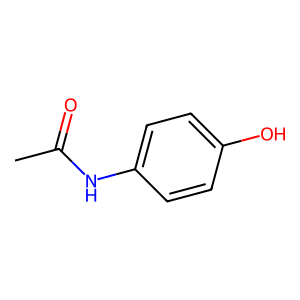

In [125]:
# @title Choose the molecule to draw { display-mode: "form" }
input = 'paracetamol' # @param {type:"string"}
input_type = 'name' # @param ["smiles", "name", "cas"] {allow-input: true}
if input_type != 'smiles' :
    smiles=cirpy.resolve( input, 'smiles')
else:
    smiles=input
img = Draw.MolToImage( Chem.MolFromSmiles(smiles), size=(300, 300) )
display(img)

## Loading the Data {-}

We need to load the Google Drive and access an example of a dataset from a kinetics experiment. You can use the same set that I am using by downloading it from Canvas, [here](). Or you can use your own files. I am assuming the file in question will be located in a `Kinetics_Data/` subfolder in your `Colab Notebook/` folder. 

In [126]:
# @title Set Local Path { display-mode: "form" }
# The following needs to be the path of the folder with all your collected data in .csv format

path = '/Users/School/PycharmProjects/PChemLab/DSC_Data/DSC/'

In order to streamline the fitting of the data, we will be storing the information that corresponds to each peak of a DSC experiment into a Python dictionary (`dict`), together with all the relevant information of that experiment and the parameters that we need for the fit. NOTE: for these experiments, since we need to fit and get information from different peaks or steps in the DSC curves, we will create a separate dictionary for each feature we want to analyze. You can use the same statement in the following, but make sure to change the file name from 'indium.txt' (the one that I am using) to the one you want to use.

In [127]:
indium_melting = {'path':path, 'name':'Indium.txt', 'label':'In Melting', 'time_start': 0, 'time_end': 0, 'baseline_type': 'line','twocolumns':True}
indium_freezing = {'path':path, 'name':'Indium.txt', 'label':'In Freezing', 'time_start': 0, 'time_end': 0, 'baseline_type': 'line','twocolumns':True}

indium_peaks = [indium_melting, indium_freezing]

We can load the data into each dictionary as follows

In [128]:
load_data_to_file_dict(indium_melting)

This will create a new component of the dictionary named 'data', which will contain a DataFrame generated from the DSC file specified in the dictionary. We should always check that the loaded data looks ok, say by checking the number of columns and rows and, maybe, plotting the two columns

In [129]:
indium_melting['data'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Index      85 non-null     int64  
 1   Heat-Flow  85 non-null     float64
 2   Time       85 non-null     int64  
 3   Tr         85 non-null     float64
 4   Ts         85 non-null     float64
dtypes: float64(3), int64(2)
memory usage: 3.4 KB


<Axes: xlabel='Time'>

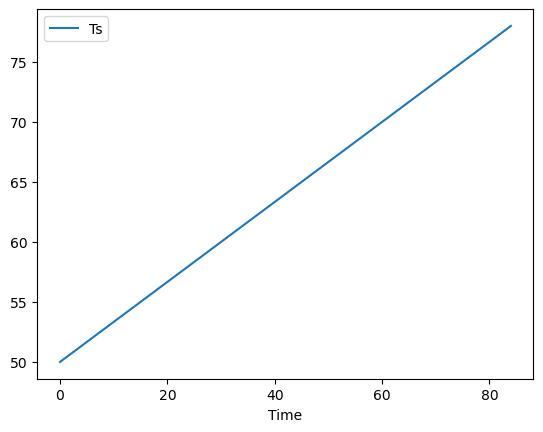

In [130]:
indium_melting['data'].plot('Time','Ts')

However, we created a set of tools that allows you to load the data, filter them on the speficied time interval, and plot them in one step. For a single dictionary you can use

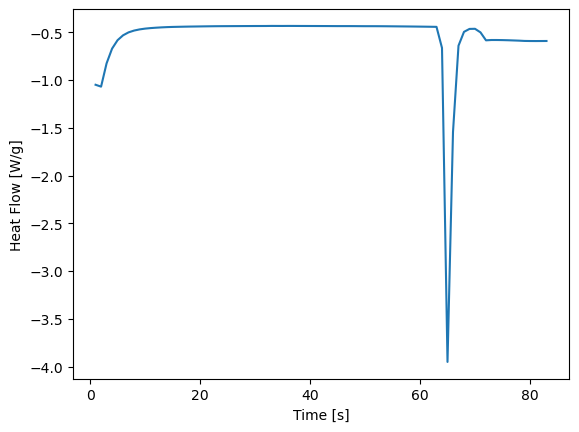

In [131]:
plot_peak(indium_melting,'Time')

But if you want to plot multiple peaks in a single plot, you can use the `plot_peak_list([peak1, peak2])` instead, which expects a list of dictionaries.

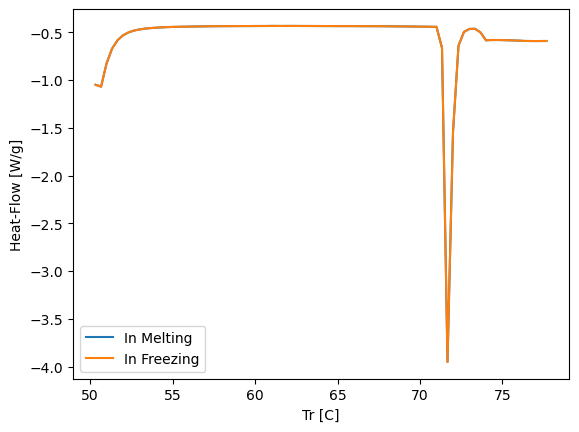

In [132]:
plot_peak_list(indium_peaks,'Tr')

## Adjust the Analysis Parameters {-}

In [133]:
# @title Find a reasonable time interval around the melting peak { display-mode: "form" }
time_start = 100 # @param {type:"number"}
time_end = 400 # @param {type:"number"}
baseline_type = 'line' # @param ['line','horizontal-line','integral','horizontal-integral'] {allow-input: true}
xaxis = 'Tr' # @param ['Time','Tr','Ts']
indium_melting['time_start'] = time_start
indium_melting['time_end'] = time_end
indium_melting['baseline_type'] = baseline_type
plot = analyze_peak(indium_melting,xaxis=xaxis,verbose=True)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
# @title Find a reasonable time interval around the freezing peak { display-mode: "form" }
time_start = 500 # @param {type:"number"}
time_end = 700 # @param {type:"number"}
baseline_type = 'line' # @param ['line','horizontal-line','integral','horizontal-integral'] {allow-input: true}
xaxis = 'Tr' # @param ['Time','Tr','Ts']
indium_freezing['time_start'] = time_start
indium_freezing['time_end'] = time_end
indium_freezing['baseline_type'] = baseline_type
analyze_peak(indium_freezing,xaxis=xaxis,verbose=True)

NOTE that the information that is printed on the graphs is also stored in the dictionaries:

In [ ]:
print(indium_melting['onset']) # this outputs the coordinates of the point
print(indium_melting['extrapolated_peak']) # this outputs the coordinates of the point

In [ ]:
plot_analysis_list(indium_peaks,xaxis='Tr')

## Check Each of Your Experiments

Repeat this analysis for each one of your curves. Make sure to take note of the times that affect your analysis the most, you will need them in your worksheet. 

In [ ]:
# @title Find a reasonable time interval around the freezing peak { display-mode: "form" }
filename = 'para1.txt' # @param {type:"string"}
time_start = 350 # @param {type:"number"}
time_end = 0 # @param {type:"number"}
baseline_type = 'line' # @param ['line','horizontal-line','integral','horizontal-integral'] {allow-input: true}
xaxis = 'Tr' # @param ['Time','Tr','Ts']
check_type = 'analyze' # @param ['plot', 'analyze']
newpeak = {'path':path, 'name':filename, 'label':'check', 'time_start': time_start, 'time_end': time_end, 'baseline_type': baseline_type}
if check_type == 'plot':
    plot_peak(newpeak,xaxis=xaxis)
elif check_type == 'analyze':
    analyze_peak(newpeak,xaxis=xaxis,verbose=True)